# Libraries import

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import skew,kurtosis
from scipy.special import boxcox1p

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

Load dataset from Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/My Drive/Datasets/insurance_data_reg.csv')

Mounted at /content/drive


# Introdoction to dataset

In [ ]:
df.head()

,uid,sex,bmi,children,smoker,expenses,weight,height,birth_year,has_car,favorite_color,region
0,2987877.0,female,27.9,0,yes,16884.92,84.239175,1.829196,2005,no,red,southwest
1,3334624.0,male,33.8,1,no,1725.55,96.367682,1.677255,2006,no,red,southeast
2,2758278.0,male,33.0,3,no,4449.46,92.328023,1.585170,1996,no,blue,southeast
3,2352741.0,male,22.7,0,no,21984.47,61.590189,1.834498,1991,no,red,northwest
4,3596946.0,male,28.9,0,no,3866.86,86.014975,1.538240,1992,no,blue,northwest


In [ ]:
df.describe()

,uid,bmi,children,expenses,weight,height,birth_year
count,1.325000e+03,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,3.022676e+06,30.665471,1.094918,13269.583946,90.632637,1.696309,1984.792975
std,7.169724e+05,6.098382,1.205493,12110.891811,34.596211,0.106943,14.049960
min,9.616670e+05,16.000000,0.000000,0.000000,42.542676,1.513196,1960.000000
25%,2.533437e+06,26.300000,0.000000,4740.287500,76.113966,1.601626,1973.000000
50%,3.018370e+06,30.400000,1.000000,9382.030000,88.098593,1.697910,1985.000000
75%,3.508208e+06,34.700000,2.000000,16639.915000,100.629409,1.788006,1997.000000
max,5.137782e+06,53.100000,5.000000,63770.430000,824.000000,1.886476,2006.000000


At first glance it's visible that for example expenses are skewed. min max mean and median were not distributed equally․

In [ ]:
## Detect dataframe shape
df.shape

(1338, 12)

# Exploration data Analysis (EDA)

## Address Missing Values

### Identify columns with missing values

In [ ]:
missing_values  = df.isna().sum()

Print features which have missing values

In [ ]:
missing_values[missing_values > 0]

uid                13
has_car            26
favorite_color    160
dtype: int64

Percentage of missing values

In [ ]:
df.isna().mean()/df.shape[0]*100

uid               0.000726
sex               0.000000
bmi               0.000000
children          0.000000
smoker            0.000000
expenses          0.000000
weight            0.000000
height            0.000000
birth_year        0.000000
has_car           0.001452
favorite_color    0.008937
region            0.000000
dtype: float64

### Address missing values

In [ ]:
df.has_car.value_counts()

no     1164
yes     148
Name: has_car, dtype: int64

I opt for addressing missing values in the "has_car" column by removing the rows that contain NaN values.
This method is suitable because the missing values account for only a small fraction of the dataset, and their removal is unlikely to have a significant impact on the analysis.

In [ ]:
df.dropna(subset=['has_car'], inplace=True)

In [ ]:
df.favorite_color.value_counts()

red      461
blue     360
green    334
Name: favorite_color, dtype: int64

Replace missing values with the most frequent value of the "favorite_color" column.

In [ ]:
mode_color = df['favorite_color'].mode()[0]
df['favorite_color'].fillna(mode_color, inplace=True)

In [ ]:
df.uid.value_counts()

2987877.0    1
3732064.0    1
2606351.0    1
2237117.0    1
2370441.0    1
            ..
3070257.0    1
2238635.0    1
3248019.0    1
2745241.0    1
4157993.0    1
Name: uid, Length: 1301, dtype: int64

In [ ]:
df.dtypes

uid               float64
sex                object
bmi               float64
children            int64
smoker             object
expenses          float64
weight            float64
height            float64
birth_year          int64
has_car            object
favorite_color     object
region             object
dtype: object

fill the "uid" column with values that are not already present in the "uid" column not to lose information

In [ ]:
# Fill NaN values in 'uid' column with a placeholder value (-1) to allow to change 'uid' type as it's float type
df['uid'].fillna(-1, inplace=True)

# Convert 'uid' column to integers
df['uid'] = df['uid'].astype(int)

# Find values not present in 'uid' column
available_ids = set(range(1, max(df['uid']) + 2))  # Generate a set of all possible ids
used_ids = set(df['uid'].unique())  # Get set of used ids
unused_ids = list(available_ids - used_ids)  # Get ids not used

# Shuffle the list of unused ids
import random
random.shuffle(unused_ids)

# Fill 'uid' column with values not present in 'uid'
df.loc[df['uid'] == -1, 'uid'] = unused_ids[:sum(df['uid'] == -1)]

In [ ]:
df.isna().sum()

uid               0
sex               0
bmi               0
children          0
smoker            0
expenses          0
weight            0
height            0
birth_year        0
has_car           0
favorite_color    0
region            0
dtype: int64

## Address Outliers

In [ ]:
df_cleaned = df.copy()

Change birth year to age as it's more suitable to use for modeling

In [ ]:
from datetime import datetime

# Calculate current year
current_year = datetime.now().year

# Calculate age from birth year
df_cleaned['age'] = current_year - df_cleaned['birth_year']

# Drop 'birth_year' column if you no longer need it
df_cleaned.drop(columns=['birth_year'], inplace=True)

In [ ]:
df_cleaned.columns

Index(['uid', 'sex', 'bmi', 'children', 'smoker', 'expenses', 'weight',
       'height', 'has_car', 'favorite_color', 'region', 'age'],
      dtype='object')

In [ ]:
df_cleaned.age

0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1312, dtype: int64

#### Identify columns with outliers.


In [ ]:
df_cleaned.dtypes

uid                 int64
sex                object
bmi               float64
children            int64
smoker             object
expenses          float64
weight            float64
height            float64
has_car            object
favorite_color     object
region             object
age                 int64
dtype: object

Print numerical features

In [ ]:
numerical_features = df_cleaned.select_dtypes(include=['int', 'float']).columns.tolist()

print("Numerical Features:", numerical_features)

Numerical Features: ['uid', 'bmi', 'children', 'expenses', 'weight', 'height', 'age']


In [ ]:
def plot_diff (feat):
  plt.figure(figsize=(15, 8))

  # Histogram
  plt.subplot(2, 1, 1)
  sns.histplot(df_cleaned[feat], kde=True)
  plt.title('Histogram')

  # Boxplot
  plt.subplot(2, 1, 2)
  sns.boxplot(x=df_cleaned[feat])
  plt.title('Boxplot')

  plt.tight_layout()
  plt.show()

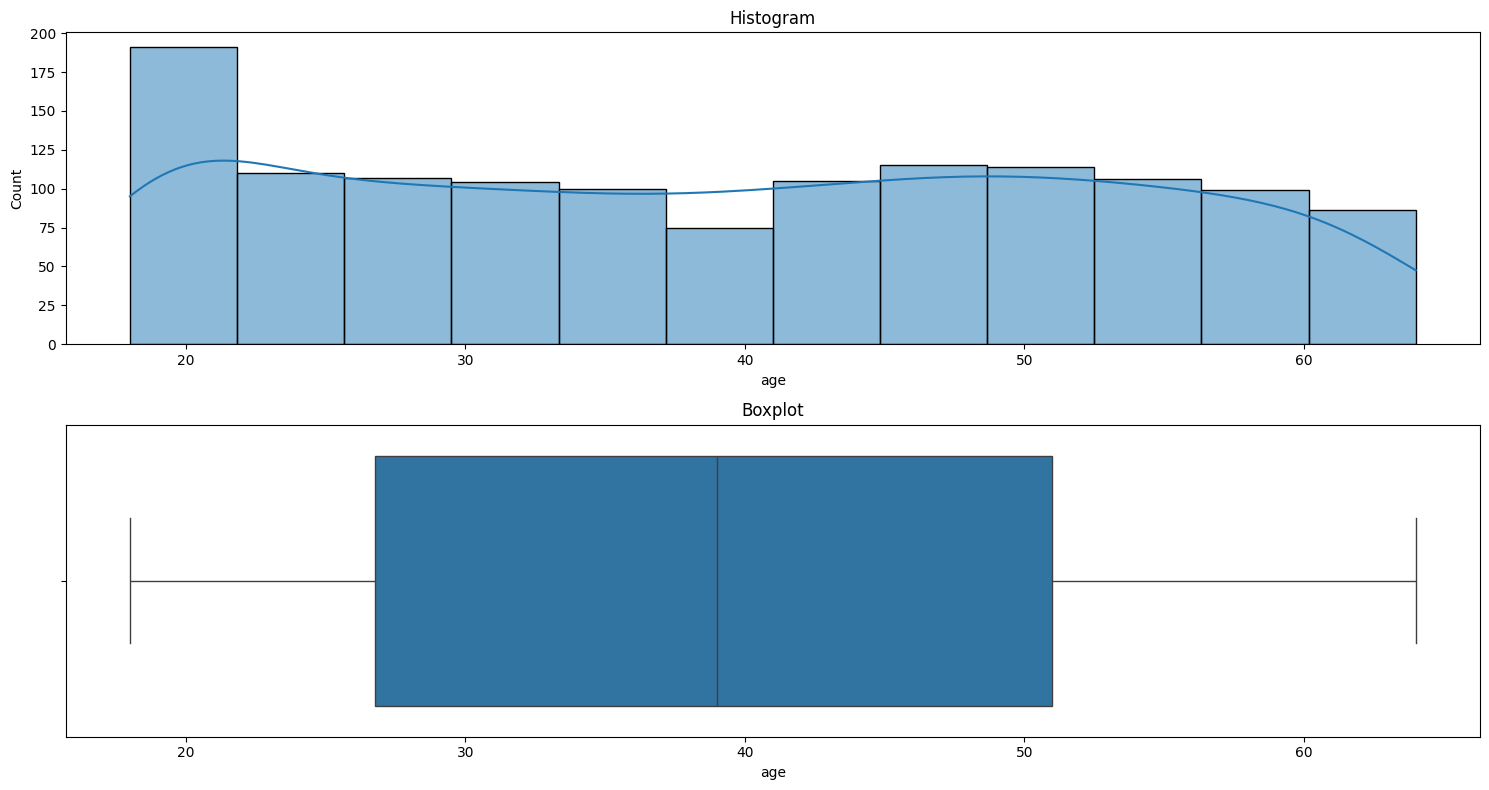

In [ ]:
plot_diff('age')

No outliers for 'age' feature

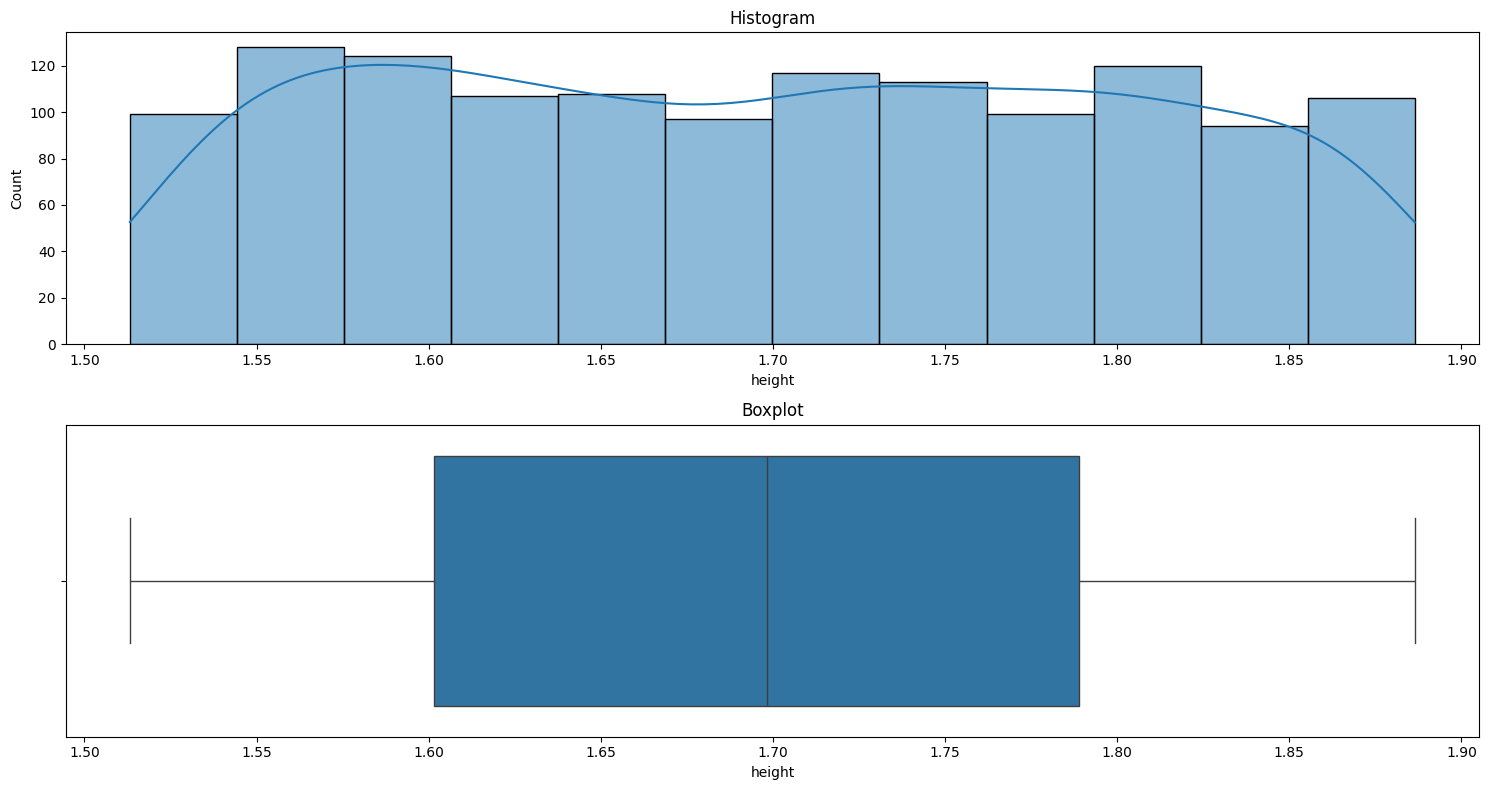

In [ ]:
plot_diff('height')

No outliers for 'height' feature

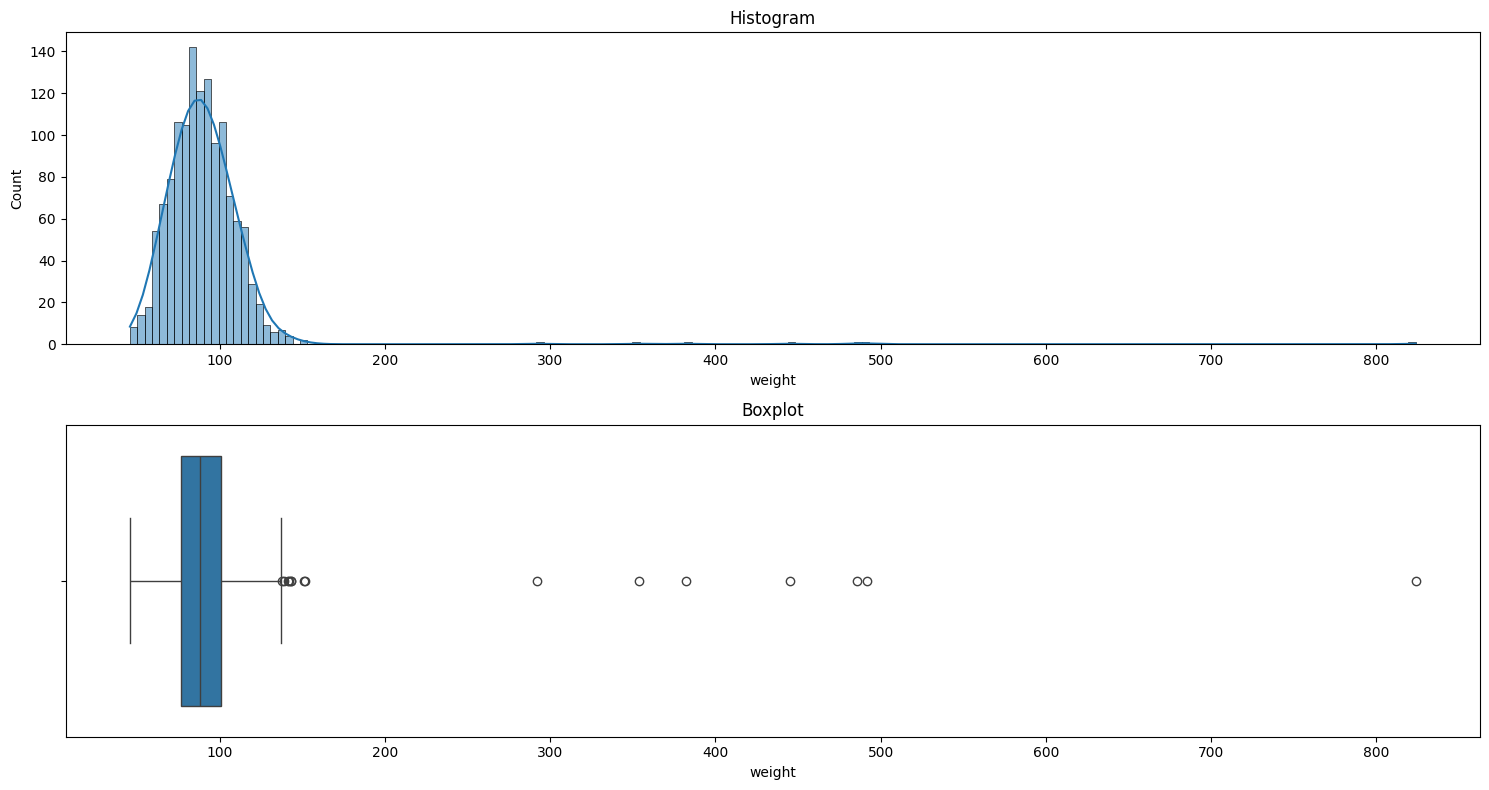

In [ ]:
plot_diff('weight')

Remove outliers

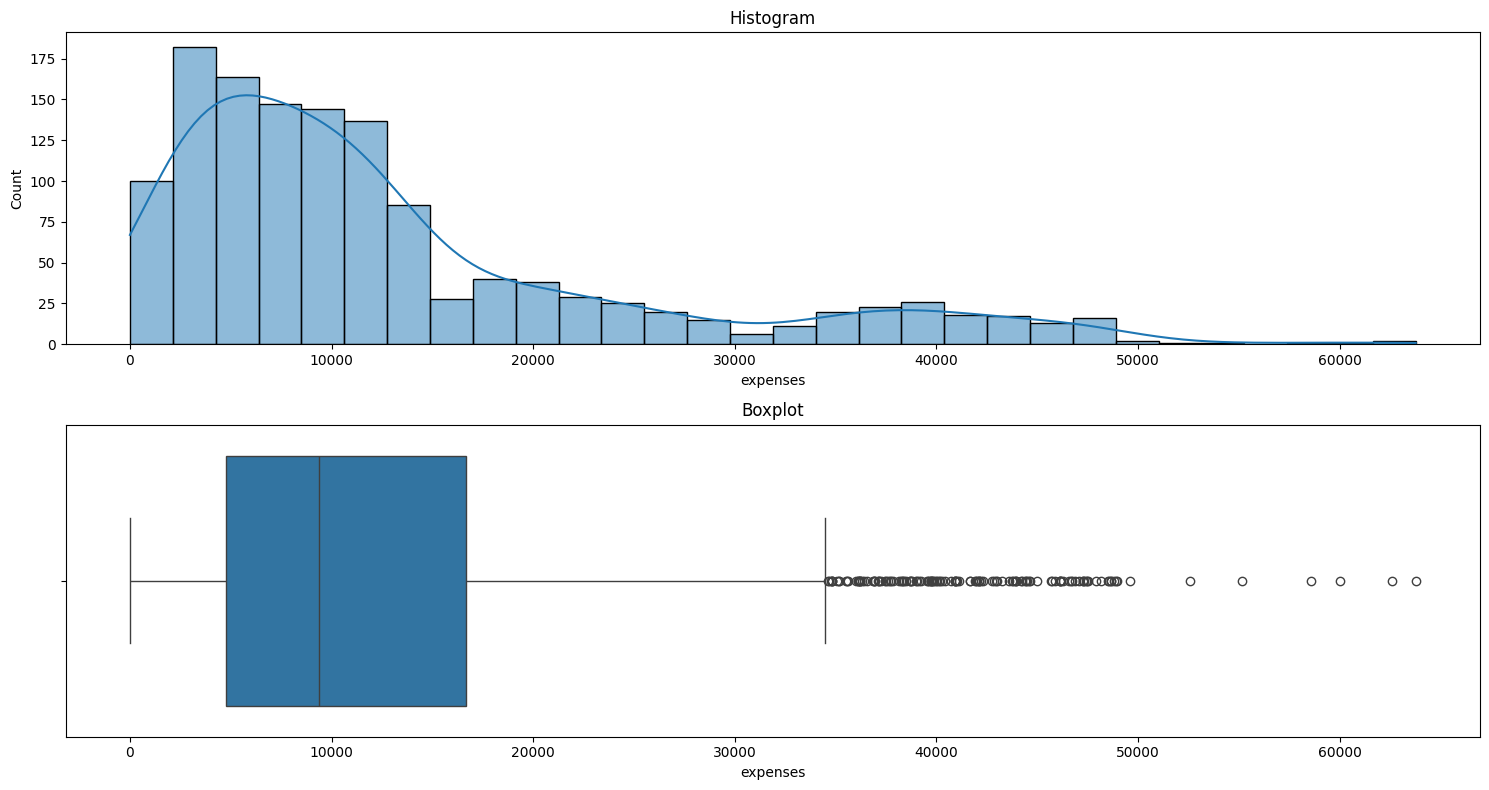

In [ ]:
plot_diff('expenses')

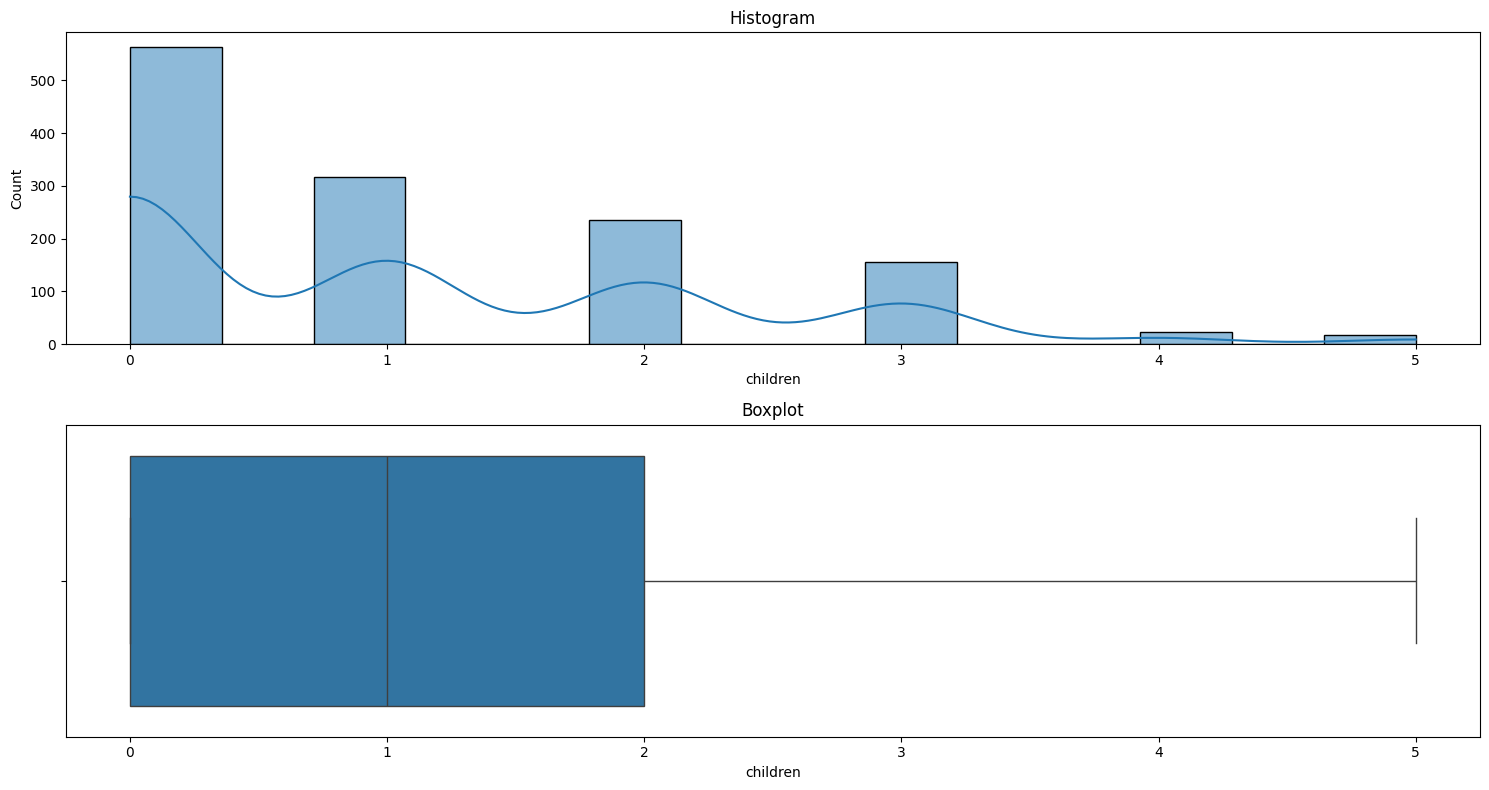

In [ ]:
plot_diff('children')

No outliers for 'children' feature

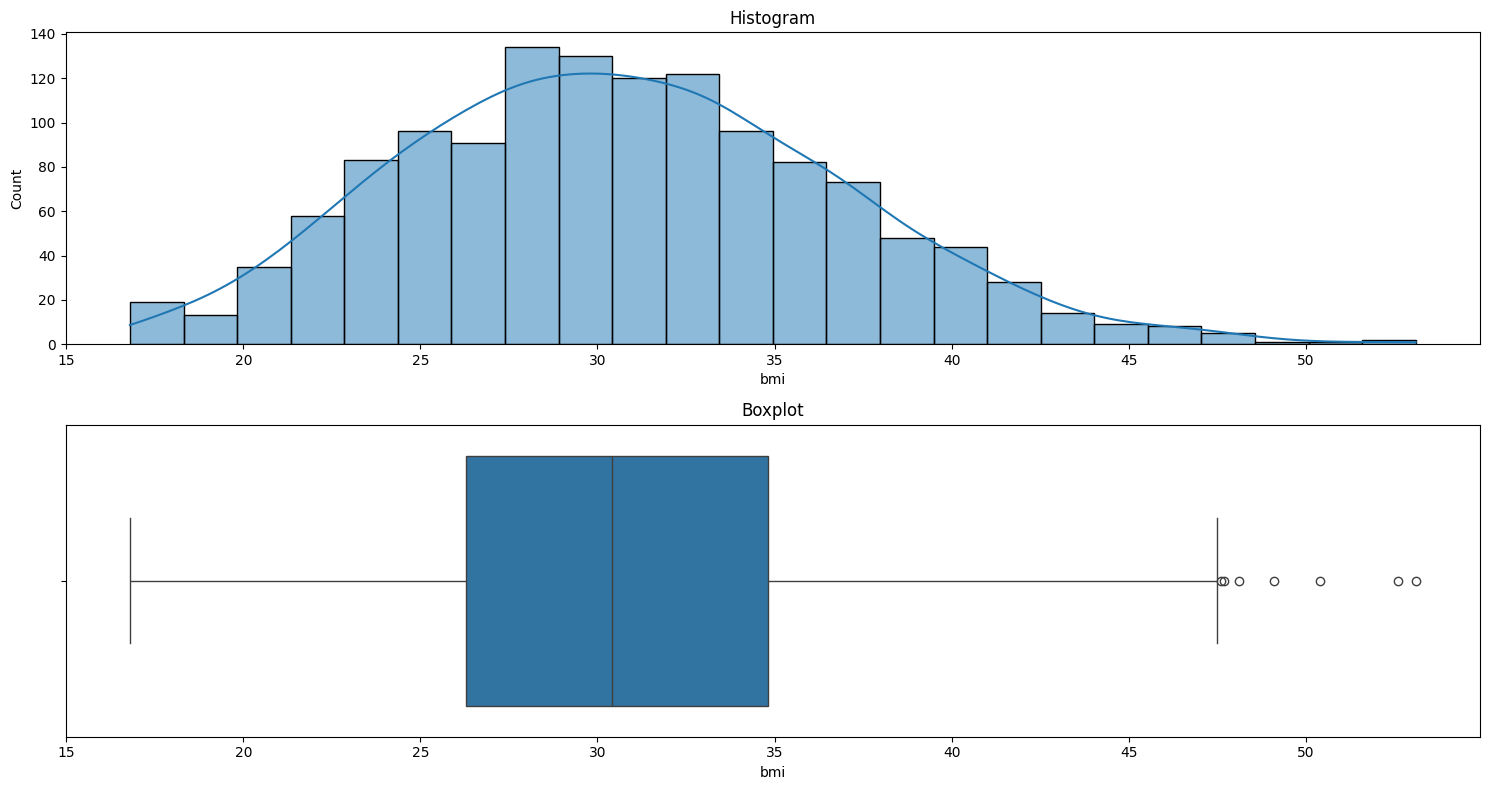

In [ ]:
plot_diff('bmi')

In [ ]:
from scipy import stats

# Calculate z-scores
df['z_score'] = stats.zscore(df['weight'])

# Identify outliers based on z-score threshold (e.g., z > 3)
outliers = df[df['z_score'].abs() > 3]['weight']

# Print outliers
print("Outliers based on z-score:")
print(outliers)

Outliers based on z-score:
579     492.0
611     824.0
656     354.0
946     445.0
1004    382.0
1178    486.0
1243    292.0
Name: weight, dtype: float64


In [ ]:
# Calculate z-scores
df['z_score'] = stats.zscore(df['bmi'])

# Identify outliers based on z-score threshold (e.g., z > 3)
outliers = df[df['z_score'].abs() > 3]['bmi']

# Print outliers
print("Outliers based on z-score:")
print(outliers)

Outliers based on z-score:
116     49.1
847     50.4
1047    52.6
1317    53.1
Name: bmi, dtype: float64


In [ ]:
# Calculate z-scores
df['z_score'] = stats.zscore(df['expenses'])

# Identify outliers based on z-score threshold (e.g., z > 3)
outliers = df[df['z_score'].abs() > 3]['expenses']

# Print outliers
print("Outliers based on z-score:")
print(outliers)

Outliers based on z-score:
543     63770.43
577     58571.07
819     55135.40
1146    52590.83
1230    60021.40
1241    49577.66
1300    62592.87
Name: expenses, dtype: float64


#### Address detected outliers

Removed detected outliers as they can mislead the model results

In [ ]:
df_cleaned = df_cleaned.loc[df_cleaned['bmi']<=49]
df_cleaned = df_cleaned.loc[df_cleaned['expenses']<=50000]
df_cleaned = df_cleaned.loc[df_cleaned['weight']<=200]

## Drop Irrelevant Features

In [ ]:
# Create an empty dictionary to store the results
features_high_frequency = {}

# Iterate over each column in the dataframe
for column in df_cleaned.columns:
    # Calculate the frequency of the most common value
    most_common_freq = df_cleaned[column].value_counts(normalize=True).iloc[0]

    # Check if the frequency is greater than 0.9 (90%)
    if most_common_freq >= 0.9:
        # Add the column and its frequency to the dictionary
        features_high_frequency[column] = most_common_freq

# Convert the dictionary to a DataFrame for better readability
features_high_frequency_df = pd.DataFrame(features_high_frequency.items(), columns=['Feature', 'Frequency'])

# Display the features with more than 90% of values being the same
print(features_high_frequency_df)

Empty DataFrame
Columns: [Feature, Frequency]
Index: []


No features detected with more than 90 % of values being the same

In [ ]:
df_cleaned.columns

Index(['uid', 'sex', 'bmi', 'children', 'smoker', 'expenses', 'weight',
       'height', 'has_car', 'favorite_color', 'region', 'age'],
      dtype='object')

Drop the features 'uid', 'has_car', 'favorite_color', 'region' as they are not directly relevant to predicting insurance expenses.

In [ ]:
# Drop features that are not relevant to insurance expenses
irrelevant_features = ['uid', 'has_car', 'favorite_color', 'region']
df_cleaned.drop(columns=irrelevant_features, inplace=True)

## Address Skewness and Kurtosis

In [ ]:
# Select numerical features
numerical_features = df_cleaned.select_dtypes(include=[np.number])
numerical_features

,bmi,children,expenses,weight,height,age
0,27.9,0,16884.92,84.239175,1.829196,19
1,33.8,1,1725.55,96.367682,1.677255,18
2,33.0,3,4449.46,92.328023,1.585170,28
3,22.7,0,21984.47,61.590189,1.834498,33
4,28.9,0,3866.86,86.014975,1.538240,32
...,...,...,...,...,...,...
1333,31.0,3,10600.55,87.002240,1.589100,50
1334,31.9,0,2205.98,92.934682,1.695332,18
1335,36.9,0,1629.83,108.492259,1.559135,18
1336,25.8,0,2007.95,79.266655,1.679933,21


In [ ]:
# Calculate skewness and kurtosis
skewness = numerical_features.skew()
kurt = numerical_features.kurtosis()

# Combine skewness and kurtosis into a DataFrame
skew_kurt = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})
skew_kurt

,Skewness,Kurtosis
bmi,0.215430,-0.297722
children,0.933348,0.191235
expenses,1.442257,1.233666
weight,0.194372,-0.286758
height,0.052034,-1.216519
age,0.046126,-1.246695


In [ ]:
skew_kurt[ (abs(skew_kurt['Skewness']) > 1) | (abs(skew_kurt['Kurtosis'] > 0)) ]

,Skewness,Kurtosis
children,0.933348,0.191235
expenses,1.442257,1.233666


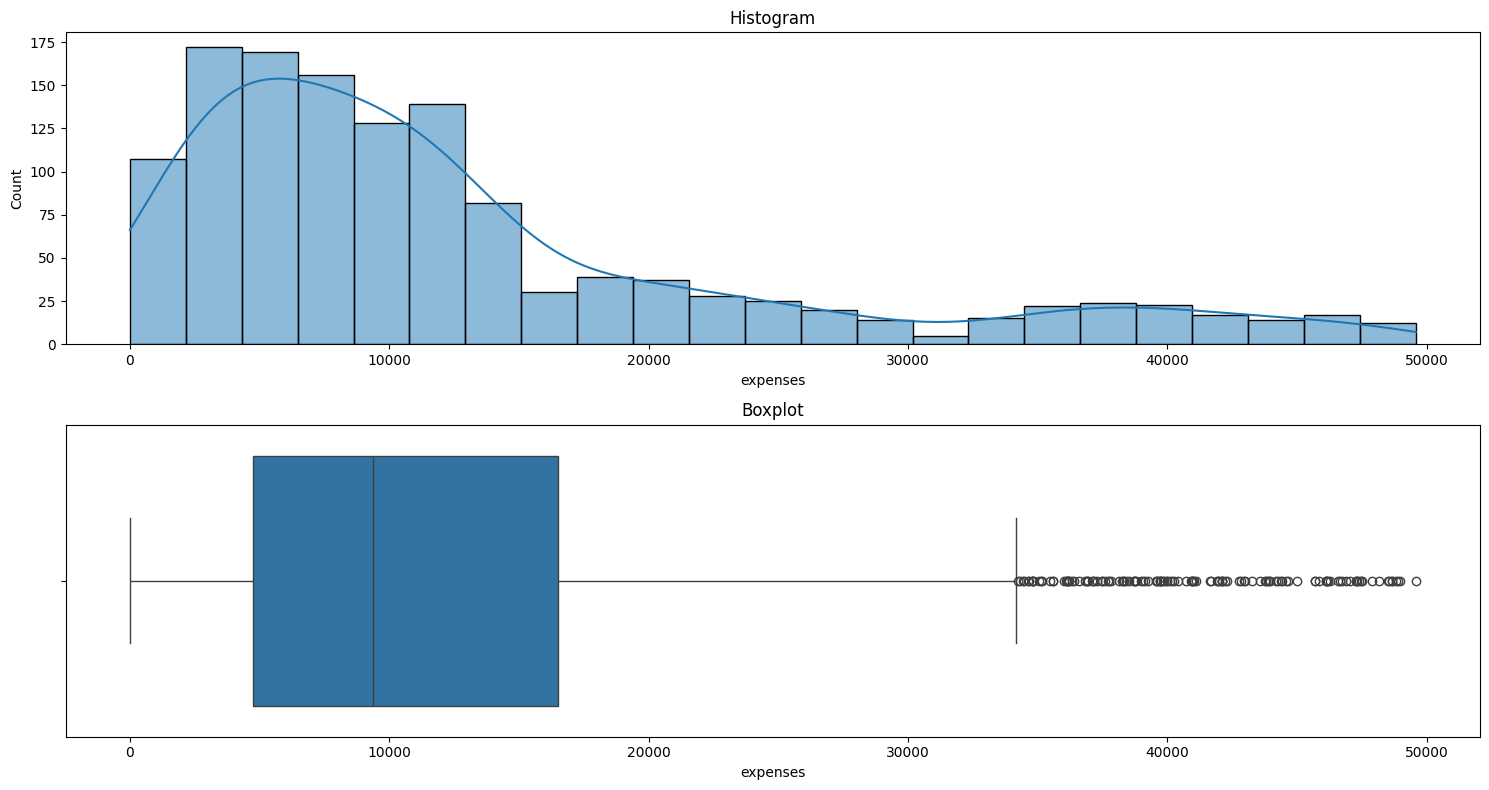

In [ ]:
plot_diff('expenses')

Skewness is greater than 1, it means that 'expenses' feature distribution is right_skewed. Also Kurtosis is high for this feature.

In [ ]:
skewness = df_cleaned['expenses'].skew() ## Skewness of expenses feature before transformation
print(f"{skewness:.3f}", 'expenses skewness')
skewness_log = np.log1p(df_cleaned['expenses']).skew() ## Skewness of expenses feature after log transformation
print(f"{skewness_log:.3f}", 'expenses skewness after log transformation')
skewness_sqrt = np.sqrt(df_cleaned['expenses']).skew() ## Skewness of expenses feature after sqrt transformation
print(f"{skewness_sqrt:.3f}", 'expenses skewness after sqrt transformation')

1.442 expenses skewness
-0.771 expenses skewness after log transformation
0.750 expenses skewness after sqrt transformation


'Expenses' feature skewness was close to normal distribution skewness after sqrt transformation

In [ ]:
## Let's calculate also kurtosis after sqrt transformation
kurtosis_sqrt = np.sqrt(df_cleaned['expenses']).kurtosis() ## Kurtosis of expenses feature after sqrt transformation
print(f"{kurtosis_sqrt:.3f}", 'expenses kurtosis after sqrt transformation')

-0.164 expenses kurtosis after sqrt transformation


Kurtosis is also close to normal distribution kurtosis after sqrt transformation

Text(0.5, 1.0, 'Density Plot of sqrt tranformation')

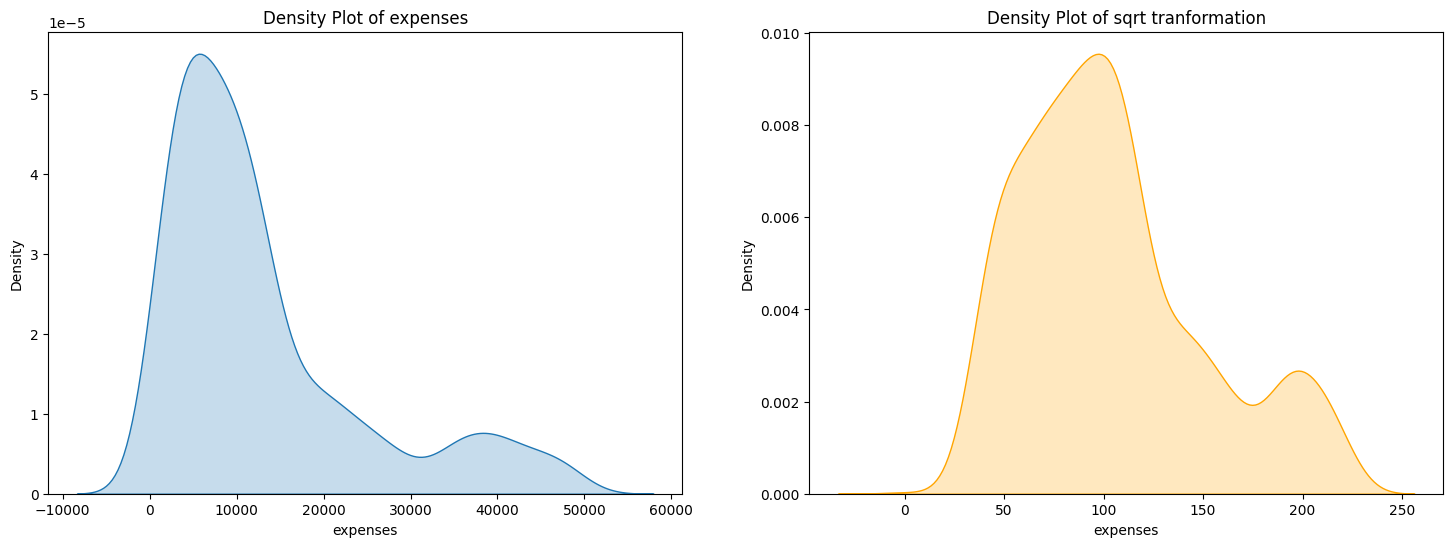

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Plotting the density curve for the original feature
plt.subplot(1, 2, 1)
sns.kdeplot(df_cleaned['expenses'], fill=True)
plt.title('Density Plot of expenses')

# Plotting the density curve for the sqrt-transformed feature
plt.subplot(1, 2, 2)
sns.kdeplot(np.sqrt(df_cleaned['expenses']), fill=True, color='orange')
plt.title('Density Plot of sqrt tranformation')

Apply sqrt transformation to normalize 'expenses' feature distribution

In [ ]:
df_cleaned['expenses'] = np.sqrt(df_cleaned['expenses'])

## Encode Categorical Features

In [ ]:
categorical_features = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist() ## List categorical features

In [ ]:
categorical_features

['sex', 'smoker']

'sex' and 'smoker' are binary features so we use Label encoding

In [ ]:
df_cleaned.columns

Index(['sex', 'bmi', 'children', 'smoker', 'expenses', 'weight', 'height',
       'age', 'Sex_encoded'],
      dtype='object')

In [ ]:
df_cleaned.sex.value_counts()

male      651
female    644
Name: sex, dtype: int64

In [ ]:
df_cleaned.smoker.value_counts()

no     1034
yes     261
Name: smoker, dtype: int64

In [ ]:
df_cleaned['sex_encoded'] = df_cleaned['sex'].map({'male': 0, 'female': 1})
df_cleaned['smoker_encoded'] = df_cleaned['smoker'].map({'no': 0, 'yes': 1})
df_cleaned.drop(columns=['sex','smoker'],inplace=True, axis=1)

In [ ]:
df_cleaned.columns

Index(['bmi', 'children', 'expenses', 'weight', 'height', 'age', 'sex_encoded',
       'smoker_encoded'],
      dtype='object')

## Correlation analysis

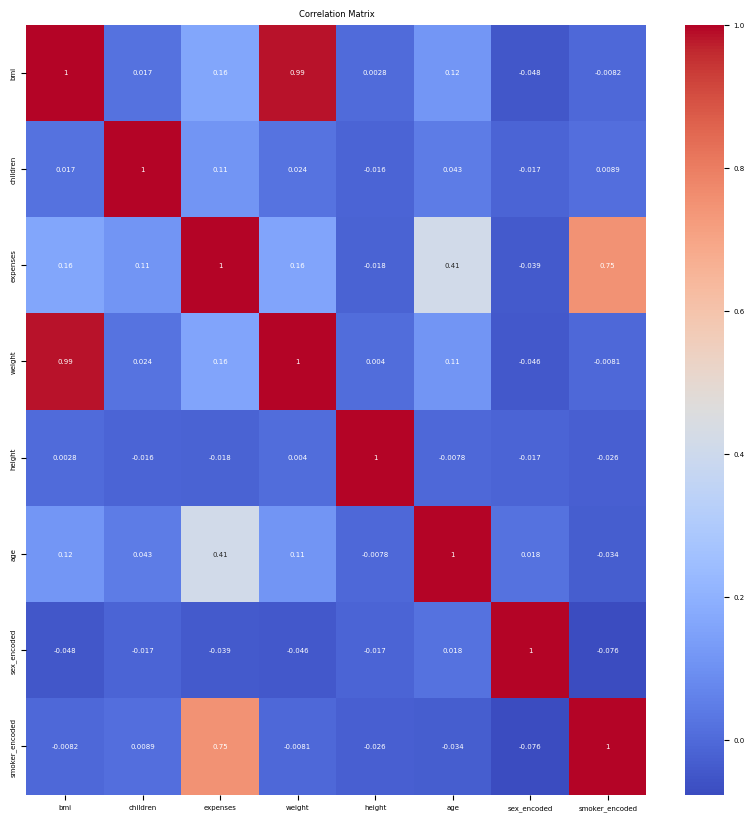

In [ ]:
corr_matrix = df_cleaned.corr(numeric_only=True)

mask = abs(corr_matrix) < 0.6
# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.rcParams['font.size'] = 5
plt.show()

In [ ]:
## features with more than 0.85 correlation
for col in corr_matrix.columns:
    corr_values = corr_matrix[col][(corr_matrix[col] > 0.7) & (corr_matrix[col] < 1.0)]
    if not corr_values.empty:
        for idx, value in corr_values.items():
            print(f"{col} - {idx}: {value}")

NameError: name 'corr_matrix' is not defined

BMI is a calculated value derived from a person's weight and height. And it's normal that correlation is high.
Weight and height may have a more direct impact on certain insurance-related factors, such as the cost of coverage for medical conditions related to weight and height. So I will drop BMI.

In [ ]:
df_cleaned.drop(columns='bmi',inplace=True,axis=1)

In [ ]:
df_cleaned.columns

Index(['children', 'expenses', 'weight', 'height', 'age', 'sex_encoded',
       'smoker_encoded'],
      dtype='object')

# Modeling

In [ ]:
# Define features and target variable
X = df_cleaned.drop(columns=['expenses'])  # Features
y = df_cleaned['expenses']  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (1036, 6)
y_train: (1036,)

Testing set shapes:
X_test: (259, 6)
y_test: (259,)


## Split the data

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fit Model 1 using unscaled features
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Make predictions on the testing set
y_pred1 = model1.predict(X_test)

# Evaluate Model 1 performance
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = mse1 ** 0.5
r_squared1 = r2_score(y_test, y_pred1)

print("Model 1 Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse1)
print("Root Mean Squared Error (RMSE):", rmse1)
print("R-squared:", r_squared1)

Model 1 Evaluation Metrics:
Mean Squared Error (MSE): 454.88675133207454
Root Mean Squared Error (RMSE): 21.32807425277947
R-squared: 0.78522747790344


## Interpretation of model results

Interpretation:

Mean Squared Error (MSE):

The MSE measures the average squared difference between the actual and predicted values. In this case, the MSE is approximately 474.9. Lower values of MSE indicate better model performance.
Root Mean Squared Error (RMSE):

The RMSE is the square root of the MSE, representing the average deviation of the predicted values from the actual values. Here, the RMSE is approximately 21.32. Lower RMSE values indicate better fit of the model to the data.
R-squared (R^2):

The R-squared value measures the proportion of the variance in the dependent variable (expenses) that is explained by the independent variables (features) in the model. An R-squared value of 0.78 indicates that approximately 78% of the variance in expenses is explained by the features included in the model. Higher R-squared values suggest better goodness of fit.
Overall, these evaluation metrics suggest that the multiple linear regression model performs reasonably well on the testing set. The relatively low RMSE and high R-squared indicate that the model captures a significant portion of the variance in expenses and provides a good fit to the data.

## Scaling

In [ ]:
df_cleaned.columns

Index(['children', 'expenses', 'weight', 'height', 'age', 'sex_encoded',
       'smoker_encoded'],
      dtype='object')

In [ ]:
# Define the features to be scaled
features_to_scale = ['children', 'weight', 'height', 'age','expenses']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected features
df_scaled = df_cleaned.copy()  # Make a copy of the DataFrame
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Print the first few rows of the scaled DataFrame
print(df_scaled.head())

   children  expenses    weight    height       age  sex_encoded  \
0 -0.910591  0.546541 -0.242584  1.233830 -1.441840            1   
1 -0.083652 -1.340684  0.451678 -0.179585 -1.513134            0   
2  1.570227 -0.803467  0.220439 -1.036196 -0.800196            0   
3 -0.910591  0.937845 -1.539061  1.283156 -0.443728            0   
4 -0.910591 -0.899965 -0.140933 -1.472765 -0.515021            0   

   smoker_encoded  
0               1  
1               0  
2               0  
3               0  
4               0  


## Models comparison

In [ ]:
X = df_scaled.drop(columns=['expenses'])  # Features
y = df_scaled['expenses']  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.2, random_state=0)

# Print the shapes of the training and testing sets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (1036, 6)
y_train: (1036,)

Testing set shapes:
X_test: (259, 6)
y_test: (259,)


In [ ]:
# Fit Model 2 using scaled features
model2 = LinearRegression()
model2.fit(X_train_scaled, y_train_scaled)

# Make predictions on the testing set
y_pred2 = model2.predict(X_test_scaled)

# Evaluate Model 2 performance
mse2 = mean_squared_error(y_test_scaled, y_pred2)
rmse2 = mse2 ** 0.5
r_squared2 = r2_score(y_test_scaled, y_pred2)

print("\nModel 2 Evaluation Metrics (Using Scaled Features):")
print("Mean Squared Error (MSE):", mse2)
print("Root Mean Squared Error (RMSE):", rmse2)
print("R-squared:", r_squared2)



Model 2 Evaluation Metrics (Using Scaled Features):
Mean Squared Error (MSE): 0.218188677415554
Root Mean Squared Error (RMSE): 0.46710670881026106
R-squared: 0.7909453515043623


Based on the evaluation metrics, Model 2 performed better than Model 1. Here's the justification:

Model Performance Comparison:

Model 1:
MSE: 454.89
RMSE: 21.33
R-squared: 0.785
Model 2 (Using Scaled Features):
MSE: 0.218
RMSE: 0.467
R-squared: 0.791
Model 2 has lower MSE and RMSE values, indicating better predictive performance in terms of minimizing prediction errors. Additionally, Model 2 has a slightly higher R-squared value, indicating that it explains a slightly higher proportion of the variance in expenses compared to Model 1.

Feature Names and Coefficients of Model 2:
To print the feature names and coefficients of the better-performing model (Model 2), you can use the following code:

In [ ]:
# Print feature names and coefficients of Model 2
print("Feature Coefficients (Model 2):")
for feature, coef in zip(X_train.columns, model2.coef_):
    print(f"{feature}: {coef}")

Feature Coefficients (Model 2):
children: 0.08199670202915992
weight: 0.1170694254342689
height: 0.012585923621927425
age: 0.41623499951892823
sex_encoded: 0.013011592025884061
smoker_encoded: 1.9053210876803506


## Interpretation of coefficients


Based on the coefficients of Model 2, which uses scaled features, we can interpret the relationship between expenses and the features as follows:

Children (children):

Coefficient: 0.082
Interpretation: For every one-standard deviation increase in the number of children covered by the insurance plan, expenses increase by approximately 0.082 standard deviations. This suggests that having more children is associated with slightly higher insurance expenses, although the effect may not be very large.

Weight (weight):

Coefficient: 0.117
Interpretation: For every one-standard deviation increase in weight, expenses increase by approximately 0.117 standard deviations. This implies that individuals with higher weight tend to have slightly higher insurance expenses, possibly due to increased health risks associated with obesity.

Height (height):

Coefficient: 0.013
Interpretation: For every one-standard deviation increase in height, expenses increase by approximately 0.013 standard deviations. However, the coefficient for height is relatively small compared to other features, suggesting that height may not have a significant impact on insurance expenses.

Age (age):

Coefficient: 0.416
Interpretation: For every one-standard deviation increase in age, expenses increase by approximately 0.416 standard deviations. This indicates that age has a relatively strong positive relationship with insurance expenses, suggesting that older individuals tend to have higher insurance expenses, possibly due to age-related health conditions and increased healthcare needs.

Sex (sex_encoded):

Coefficient: 0.013
Interpretation: The coefficient for sex_encoded suggests that there is a slight positive relationship between sex and expenses. However, since sex is binary encoded, the interpretation should be cautious. This coefficient indicates that male (encoded as 1) tends to have slightly higher expenses compared to female (encoded as 0), after accounting for other factors in the model.

Smoker Status (smoker_encoded):

Coefficient: 1.905
Interpretation: For individuals who are smokers (encoded as 1), expenses increase by approximately 1.905 standard deviations compared to non-smokers (encoded as 0). This coefficient is notably larger compared to other features, indicating that smoking status has a substantial impact on insurance expenses, with smokers incurring significantly higher expenses compared to non-smokers.

These interpretations provide insights into how each feature contributes to the prediction of insurance expenses in the better-performing Model 2.

# Hyphotesis testing

Null Hypothesis (H0):

The mean expenses for people with 0 children are equal to the mean expenses for people with any number of children other than 0.
Alternative Hypothesis (H1):

The mean expenses for people with 0 children are different from the mean expenses for people with any number of children other than 0.

In [ ]:
# Expenses for people with 0 children
expenses_0_children = df_cleaned[df_cleaned['children'] == 0]['expenses']

# Expenses for people with any number of children other than 0
expenses_other_children = df_cleaned[df_cleaned['children'] > 0]['expenses']

In [ ]:
# Perform two-sample t-test as we have 2 groups
t_statistic, p_value = ttest_ind(expenses_0_children, expenses_other_children)

# Print the results
print("Results of Two-Sample t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Define significance level
alpha = 0.05

# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the mean expenses between people with 0 children and people with any number of children other than 0.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the mean expenses between people with 0 children and people with any number of children other than 0.")

Results of Two-Sample t-test:
t-statistic: -3.6634630363055645
p-value: 0.000258887547668943
Reject the null hypothesis. There is a significant difference in the mean expenses between people with 0 children and people with any number of children other than 0.


Relationship Between Number of Children and Expenses:

The significant difference in mean insurance expenses between the two groups suggests that the presence or absence of children plays a crucial role in determining insurance expenses.

Individuals with children may have higher insurance expenses due to increased healthcare needs for their family, including medical care for children, maternity care, and family health insurance plans.

On the other hand, individuals without children may have lower insurance expenses as they do not have additional dependents to cover.